Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [mix]
Sampling 10 chains for 1_000 tune and 4_000 draw iterations (10_000 + 40_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


hier kommen die warm up samples
<xarray.DataArray 'mix' (chain: 10)> Size: 80B
array([7.14929037, 4.86971636, 6.1635293 , 7.63901434, 5.87509618,
       6.4702383 , 9.0739248 , 4.41135231, 5.15802324, 0.89710769])
Coordinates:
  * chain    (chain) int64 80B 0 1 2 3 4 5 6 7 8 9
    draw     int64 8B 0
hier kommen die samples
<xarray.DataArray 'mix' (chain: 10)> Size: 80B
array([10.57408219,  0.8659417 ,  9.68807677, 10.36196726,  9.99780537,
       10.60653785, 10.35156328,  1.40518   ,  1.56164886,  1.10018358])
Coordinates:
  * chain    (chain) int64 80B 0 1 2 3 4 5 6 7 8 9
    draw     int64 8B 0


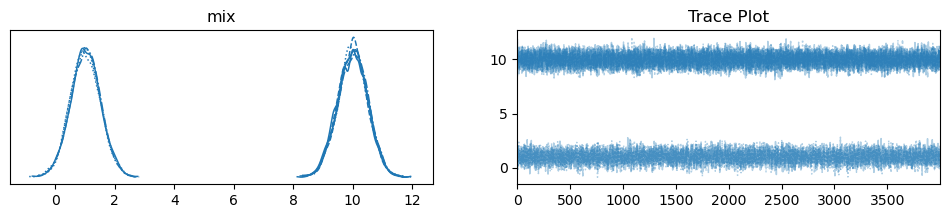

In [25]:

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt



# Define the mixture model    
with pm.Model() as model:
    # Mixture model
    mixed_post_var = pm.Mixture("mix", w= [0.5, 0.5], comp_dists=[pm.Normal.dist(1,0.5), pm.Normal.dist(10,0.5)])

    trace = pm.sample(4000, tune=1000, discard_tuned_samples=False, chains= 10, return_inferencedata=True, progressbar=False, random_seed=42) #discard_tuned_samples=False #step=pm.Metropolis()




print("hier kommen die warm up samples")

print(trace.warmup_posterior["mix"].sel(draw=0))

print("hier kommen die samples")

print(trace.posterior["mix"].sel(draw=0))


az.plot_trace(trace, compact=True)
plt.title(f"Trace Plot")
plt.show()


Multiprocess sampling (10 chains in 4 jobs)
Metropolis: [cust_var]
Sampling 10 chains for 1_000 tune and 4_000 draw iterations (10_000 + 40_000 draws total) took 10 seconds.


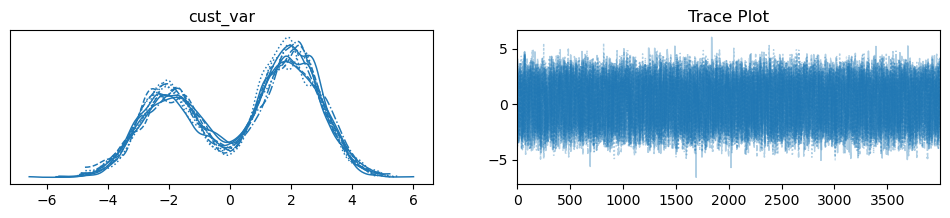

In [13]:
def my_custom_logp_function(x):
    w1, w2 = 0.4, 0.6
    mu1, mu2 = -2, 2
    sigma1, sigma2 = 1, 1

    log_like1 = pm.logp(pm.Normal.dist(mu=mu1, sigma=sigma1), x)
    log_like2 = pm.logp(pm.Normal.dist(mu=mu2, sigma=sigma2), x)

    return pm.math.logsumexp([np.log(w1) + log_like1, np.log(w2) + log_like2])


with pm.Model() as model:
    custom_var = pm.CustomDist("cust_var", logp = my_custom_logp_function)

    trace = pm.sample(4000, tune=1000, step=pm.Metropolis(), chains= 10, return_inferencedata=True, progressbar=False, random_seed=42)

az.plot_trace(trace, compact=True)
plt.title(f"Trace Plot")
plt.show()


In [10]:
import pymc as pm
import numpy as np
import arviz as az
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# 1. Referenz-Modell mit Normalverteilung
with pm.Model() as model_standard:
    x = pm.Normal("x", mu=0, sigma=1)
    trace_standard = pm.sample(1000, chains=2, random_seed=42, progressbar=False)

# 2. CustomDist mit expliziter logp-Funktion
def normal_logp(value):
    # Log-Dichte einer Normalverteilung mit mu=0, sigma=1
    return -0.5 * pt.log(2 * np.pi) - 0.5 * value**2

with pm.Model() as model_custom:
    x_custom = pm.CustomDist("x_custom", logp=normal_logp)
    trace_custom = pm.sample(1000, chains=2, random_seed=42, progressbar=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_custom]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


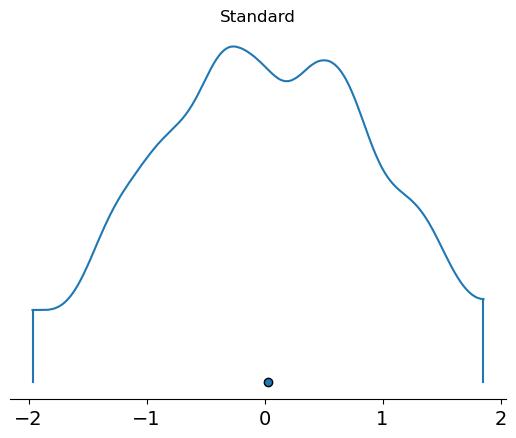

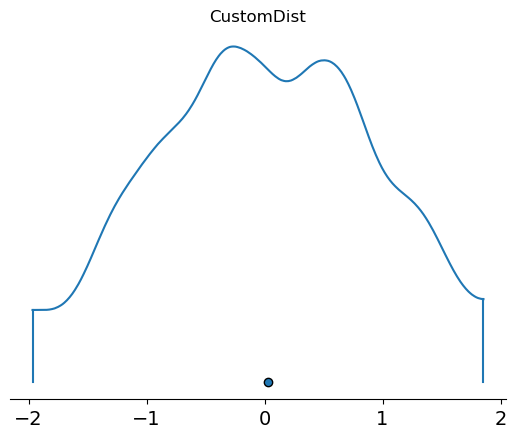

Summary für Standard:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.032,1.034,-1.97,1.859,0.031,0.023,1119.0,1228.0,1.01



Summary für CustomDist:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x_custom,0.032,1.034,-1.97,1.859,0.031,0.023,1119.0,1228.0,1.01


In [13]:
# Zwei separate Plots
az.plot_density(trace_standard, var_names=["x"])
plt.title("Standard")
plt.show()

az.plot_density(trace_custom, var_names=["x_custom"])
plt.title("CustomDist")
plt.show()


print("Summary für Standard:")
display(az.summary(trace_standard, var_names=["x"]))

print("\nSummary für CustomDist:")
display(az.summary(trace_custom, var_names=["x_custom"]))

Initializing SMC sampler...
Sampling 2 chains in 2 jobs


Output()

We recommend running at least 4 chains for robust computation of convergence diagnostics


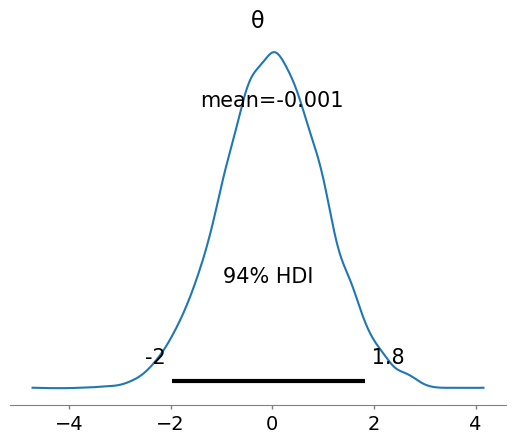

In [46]:
import pymc as pm
import pytensor.tensor as pt
import numpy as np
import arviz as az
import matplotlib.pyplot as plt



def logp_fn(θ):
    return -0.5 * θ**2 - 0.5 * np.log(2 * np.pi)  # Standardnormal

with pm.Model() as model:
    # Wichtig: nicht Flat, sondern etwas, das samplbar ist
    θ = pm.Uniform("θ", lower=-20, upper=20)

    pm.Potential("custom_logp", logp_fn(θ))

    trace = pm.sample_smc(draws=5000, chains=2, random_seed=42)



# z. B. einfaches Posterior-Plot
az.plot_posterior(trace, var_names=["θ"])
plt.show()



In [ ]:

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import arviz as az


# Define the mixture model    
with pm.Model() as model:
    # Mixture model
    init_test = pm.Normal("yo", mu=6.7, sigma=1)

    trace = pm.sample(chains=5, step = pm.Metropolis(), discard_tuned_samples=False, initvals= 9)

  

print(trace.warmup_posterior["yo"].sel(draw=2))


print(model.initial_point())






TypeError: object of type 'int' has no len()

In [43]:
with pm.Model() as model:
    yo = pm.Normal("yo", mu=6.4, sigma=1)

    initial_points = [model.initial_point() for _ in range(10)]
    print(initial_points)


[{'yo': array(6.4)}, {'yo': array(6.4)}, {'yo': array(6.4)}, {'yo': array(6.4)}, {'yo': array(6.4)}, {'yo': array(6.4)}, {'yo': array(6.4)}, {'yo': array(6.4)}, {'yo': array(6.4)}, {'yo': array(6.4)}]


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mix]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mix]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mix]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mix]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mix]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mix]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


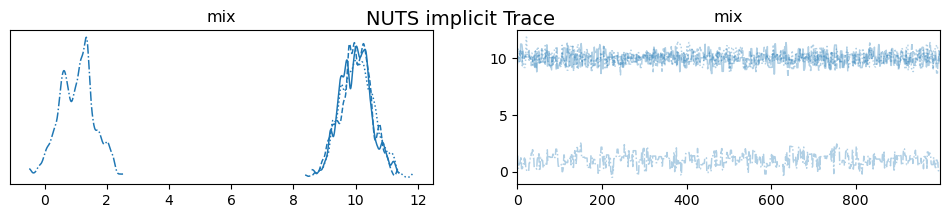

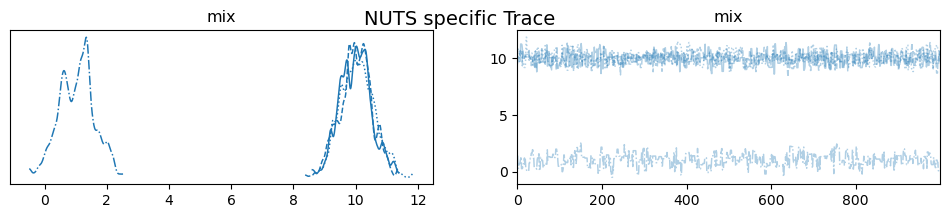

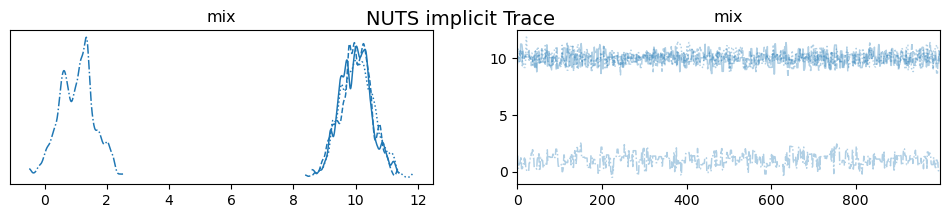

hier kommen die warm up samples von implicit
<xarray.DataArray 'mix' (chain: 4)> Size: 32B
array([6.79632476, 5.79644429, 6.17223952, 5.72077191])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
    draw     int64 8B 0
hier kommen die samples von explicit
<xarray.DataArray 'mix' (chain: 4)> Size: 32B
array([9.47980111, 9.61729369, 9.71571271, 1.38063427])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
    draw     int64 8B 0
hier kommen die samples von implicit_2
<xarray.DataArray 'mix' (chain: 4)> Size: 32B
array([9.47980111, 9.61729369, 9.71571271, 1.38063427])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
    draw     int64 8B 0
hier kommen die samples von implicit_3
<xarray.DataArray 'mix' (chain: 4)> Size: 32B
array([9.47980111, 9.61729369, 9.71571271, 1.38063427])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
    draw     int64 8B 0
hier kommen die samples von implicit_4
<xarray.DataArray 'mix' (chain: 4)> Size: 32B
array([9.47980111, 9.61729369, 9.71571271, 

In [10]:

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import arviz as az


# Define the mixture model    
with pm.Model() as model:
    # Mixture model
    mixed_post_var = pm.Mixture("mix", w= [0.5, 0.5], comp_dists=[pm.Normal.dist(1,0.5), pm.Normal.dist(10,0.5)])

    trace_metro_1 = pm.sample(step = pm.Metropolis(), discard_tuned_samples=False, random_seed=42)
    trace_metro_2 = pm.sample(step = pm.Metropolis(), discard_tuned_samples=False, random_seed=42)
    trace_metro_3 = pm.sample(step = pm.Metropolis(), discard_tuned_samples=False, random_seed=42)
    trace_metro_4 = pm.sample(step = pm.Metropolis(), discard_tuned_samples=False, random_seed=42)
    trace_metro_5 = pm.sample(step = pm.Metropolis(), discard_tuned_samples=False, random_seed=42)
    trace_metro_6 = pm.sample(step = pm.Metropolis(), discard_tuned_samples=False, random_seed=42)


# Plot HMC trace
az.plot_trace(trace_metro_1, var_names=["mix"], compact=True)
plt.suptitle("NUTS implicit Trace", fontsize=14)
plt.show()

# Plot Metropolis trace
az.plot_trace(trace_metro_2, var_names=["mix"], compact=True)
plt.suptitle("NUTS specific Trace", fontsize=14)
plt.show()


# Plot HMC trace
az.plot_trace(trace_metro_3, var_names=["mix"], compact=True)
plt.suptitle("NUTS implicit Trace", fontsize=14)
plt.show()

print("hier kommen die warm up samples von implicit")

print(trace_metro_1.warmup_posterior["mix"].sel(draw=0))

print("hier kommen die samples von explicit")

print(trace_metro_2.posterior["mix"].sel(draw=0))

print("hier kommen die samples von implicit_2")
print(trace_metro_3.posterior["mix"].sel(draw=0))

print("hier kommen die samples von implicit_3")
print(trace_metro_4.posterior["mix"].sel(draw=0))
print("hier kommen die samples von implicit_4")
print(trace_metro_5.posterior["mix"].sel(draw=0))
print("hier kommen die samples von implicit_5")
print("hier kommen die samples von implicit_6")
print(trace_metro_6.posterior["mix"].sel(draw=0))

